In [1]:
from sklearn import datasets
import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(1)

dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
# We drop Longitude as well since Latitude has enough information
X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

n = X_train.shape[0]
d = X_train.shape[1]

In [2]:
SoftThresh = lambda x, tau: np.sign(x) * np.maximum(np.abs(x)-tau, 0.0)
GD_loss = lambda A,x, y: np.linalg.norm(A.dot(x) - y, 2) ** 2 / (2. * A.shape[0]) 
GD_grad = lambda A, x, y: (A.T).dot(A.dot(x) - y)*(1/A.shape[0])

ridge_loss = lambda A, x, y, lbda: GD_loss(A,x,y) + lbda* np.linalg.norm(x,2) ** 2 / 2.
ridge_grad = lambda A, x, y, lmbd: GD_grad(A,x,y) + 1*lmbd*x


def GD_ridge(X, y, niter, step=0.001, lmbd=0):
    n, d = X.shape
    L = np.linalg.norm(X, 2) ** 2 / n + lmbd
    step = 1/L
    theta = np.ones(X.shape[1])
    loss_evol = np.zeros(niter)
    for i in range(niter):
        error_k = np.dot(X, theta) - y
        g = ridge_grad(X, theta, y, lmbd)
        theta = theta - (1/L)*g
        loss_evol[i] = ridge_loss(X, theta, y, lmbd)
    return theta, loss_evol

def ISTA(A, y, lbda, step, niter):
    (n, d) = A.shape
    x = np.ones(d)
    
    Func = [GD_loss(A,x, y)]

    for k in range(niter):
        g = GD_grad(A,x, y) #smooth part
        x = SoftThresh(x - step*g, step*lbda)
        Func.append(GD_loss(A,x,y))

    return x, Func

# $\ell_2$-norm
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_2}(\mathbf{x}) = \frac{1}{2n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2} \|x\|^2,
$$

Squared solution norm with lbda=0: 0.7296506515343141
Squared solution norm with lbda=0.01: 0.6994782321101545
Squared solution norm with lbda=1: 0.12667355113865908
Squared solution norm with lbda=10: 0.004342975129800738
Squared solution norm with lbda=100: 5.2279545420169395e-05


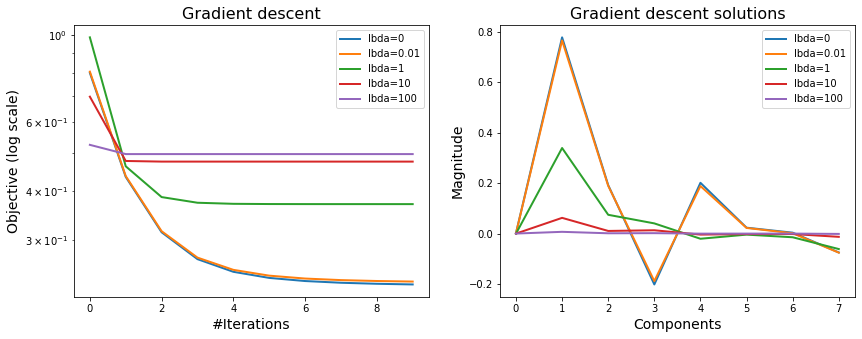

In [3]:
import matplotlib.pyplot as plt

# Testing l2 regularization
lvals = [0,0.01,1,10,100] #GD, small, big
nlbda = len(lvals)
x0 = np.ones(d)
n_iter =10
Xsol = np.zeros((d,nlbda))

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
for i in range(nlbda):
    lbda =lvals[i]
    # Xsol[:,i], obj_gd, _,_ = gd_l2(x0,pblinreg,lbda,x_min_lin,stepchoice=0,step0=1, n_iter=n_iter)
    Xsol[:,i], obj_gd = GD_ridge(X_train, y_train, n_iter, step=1, lmbd=lbda)
    print("Squared solution norm with lbda="+str(lbda)+": "+str(np.linalg.norm(Xsol[:,i])**2))
    plt.semilogy(obj_gd, label="lbda="+str(lbda), lw=2)
plt.title("Gradient descent", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,2,2)
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("Gradient descent solutions", fontsize=16)
plt.xlabel("Components", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1);

Interpretation 
1) In terms of linear algebra: Regularizing the optimality conditions linear system $\mathbf{A}^T \mathbf{A} \mathbf{x} = \mathbf{A}^T \mathbf{y}$ into another system with a unique solution for $\lambda>0$.

2) In terms of optimization: The regularized optimization problem is strongly convex (and continuous), hence it possesses a single global minimum.

3) As $\lambda \rightarrow \infty$, the regularization term reduces the dependency of the solution to the data, and, consequently, its variance with respect to the data.

4) Implicitly, this regularization enforces a constraint on the $\ell_2$ norm of the solution.

The $\ell_2$ norm smoothes out the solution and leads to solutions with increasingly smaller norms. We can observe 
that the solution components shrink in a rather uniform (aka, smooth) fashion.

# $\ell_1$-norm

Behavior of ISTA for several values of the regularization parameter, namely:
$$
    \left\{0, \frac{1}{100}, \frac{1}{10}, \frac{1}{5} 1\right\}.
$$

Nonzero coefficients with lbda=0: 8
0.22574871790959067
Nonzero coefficients with lbda=0.01: 7
0.22816156093754403
Nonzero coefficients with lbda=0.1: 2
0.25561725617836106
Nonzero coefficients with lbda=0.2: 1
0.28167669143711305
Nonzero coefficients with lbda=1: 0
0.4988891035164989


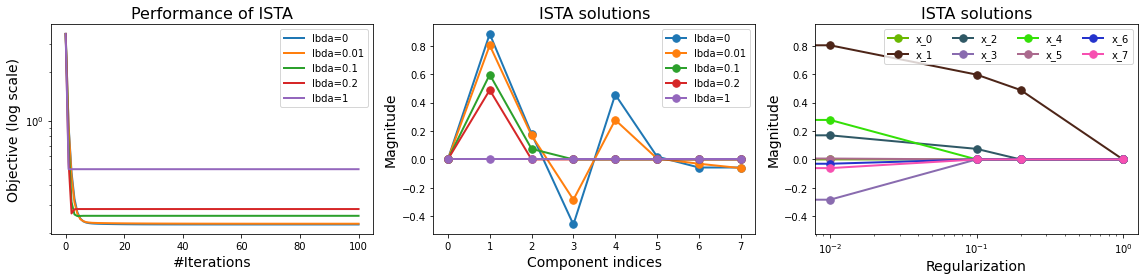

In [4]:
# Testing l1 regularization
penalties = [0, 0.01, 0.1,0.2, 1]
nlbda = len(penalties)
x0 = np.ones(d)
n_iter = 100
Xsol = np.zeros((d,nlbda))
train_loss = np.zeros(len(penalties))

plt.figure(figsize=(16, 4), tight_layout=True)

plt.subplot(1,3,1)
for i in range(nlbda):
    lbda =penalties[i]
    # Xsol[:,i], obj_is = ista(x0,pblinreg,lbda,stepchoice=0,step0=1, n_iter=n_iter)
    Xsol[:,i], obj_is = ISTA(X_train, y_train, lbda, step=1, niter=n_iter)
    print("Nonzero coefficients with lbda="+str(lbda)+": "+str(np.count_nonzero(Xsol[:,i])))
    plt.semilogy(obj_is, label="lbda="+str(lbda), lw=2)
    print(obj_is[-1])
    train_loss[i] = obj_is[-1]
    
plt.title("Performance of ISTA", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,3,2)
for i in range(nlbda):
    plt.plot(Xsol[:,i],'.-', markersize=15, label="lbda="+str(penalties[i]), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Component indices", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.subplot(1,3,3)
for i in range(d):
    plt.plot(penalties, Xsol[i,:],'.-', markersize=15, label="x_"+str(i),c=np.random.rand(3,), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xticks(penalties)
plt.xscale('log')
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1);

Confirmation: $\ell_1$ regularization leads to sparser solutions. Indeed, as we increase the regularization parameter, the number of zero components increase (and only the largest components remain).

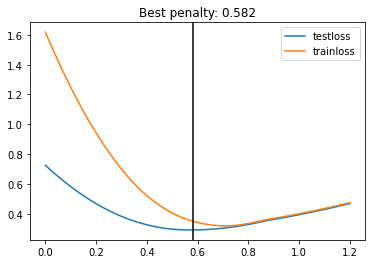

In [6]:
penalties = np.linspace(start=0.00, stop=1.2, num=100)
n_iter = 100
step = 0.01
Xsol = np.zeros((d,len(penalties)))
train_loss = np.zeros(len(penalties))
test_loss = np.zeros(len(penalties))

for i in range(len(penalties)):
    lbda =penalties[i]
    Xsol[:,i], obj_is = ISTA(X_train, y_train, lbda, step, n_iter)
    train_loss[i] = obj_is[-1]
    test_loss[i] = GD_loss(X_test, Xsol[:,i], y_test)

plt.plot(penalties, train_loss, label='testloss')
plt.plot(penalties, test_loss, label='trainloss')
min_i = np.argmin(train_loss)
plt.axvline(penalties[min_i], c='k')
plt.title(f'Best penalty: {np.round(penalties[min_i], 3)}')
plt.legend();